# Multiserotype Dengue dynamics Modeling 

# Read me

This jupyter notebook includes the implementation and simulations of the Model in the submitted paper:

### A mathematical model for the population dynamics of Dengue multiserotype interactions


### Contents 

1. libraries
2. model definition
3. parameters
4. reproductive numbers 
5. reinfection matrices
6. ode solver ivp
7. ode solutions in data frames


## 1. Libraries and modules

In [1]:
from platform import python_version

print(python_version())

3.7.6


In [2]:
import matplotlib.pylab as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


from pandas.plotting import scatter_matrix

import pandas as pd

import seaborn as sns

#print(__version__) # requires version >= 1.9.0


import numpy as np

import io, os, sys

from scipy.integrate import odeint


#from random import random
import random

from scipy.integrate import solve_ivp

### Save path files

In [29]:
#function for saving figures with names
files_path = 'files_path/'
if not os.path.isdir(files_path): os.makedirs(files_path)

## 2. Model

In [4]:
def suw4v_mass_model_ivp(t,X,Pih,Piv,aVec,bVec,gVec,rwVec,p1,p2,p3,p4,k):
    S,U1,U2,U3,U4,W1,W2,W3,W4,R,Sv,V1,V2,V3,V4=X
    

    p=np.array([p1,p2,p3,p4])
    
 
    rw1,rw2,rw3,rw4=rwVec
    
    a=aVec
    b=bVec
    g=gVec
    
    rw=rwVec
    gw=rw*gVec
    gr=(1-rw)*gVec
    
    
    #N=S+U1+U2+U3+U4+W1+W2+W3+W4+R
    #M=Sv+V1+V2+V3+V4

    M=1
    N=1
    
    q=muv*M*(1+k*np.cos(2*np.pi*t/365))
    
    #N=Pih/muh
    #M=Piv/muv
    
    U=np.array([U1,U2,U3,U4])
    W=np.array([W1,W2,W3,W4])
    #T=np.array([T1,T2,T3,T4])
    V=np.array([V1,V2,V3,V4])
    
    
    A=a*U/N
    B=b*V/N
    #B=[b*Vn/N for b,Vn in zip(bVec,V)]
    
    dS=muh*N-(B.sum()+muh)*S
    dU=B*(S+np.dot(p.T,W))-(g+muh)*U
    dW=gw*U-W*np.dot(p,B)-muh*W
    dR=np.dot(gr,U)-muh*R
    
    dSv=q-A.sum()*Sv-muv*Sv
    dV=A*Sv-muv*V
    
    return(dS,*dU,*dW,dR,dSv,*dV)


## 3. Reproductive numbers

In [5]:
# reproductive number
#4. R0s and reinf params GAS for MASS ACTION MODEL
def ri0s_mass_suw4v(aVec,bVec,gVec,muh,muv):
    alphas=[a/(g+muh) for a,g in zip(aVec,gVec)]
    betas=[b/(muv)for b in bVec]
    Ninf=1
    Minf=1
    
    #1. r0s
    ri0s=[np.sqrt((alpha*beta)*(Minf/Ninf)) for alpha,beta in zip(alphas,betas)]
    
    return(ri0s)


## 4. Reinfection  Matrices

In [6]:
# Latex form from https://stackoverflow.com/questions/17129290/numpy-2d-and-1d-array-to-latex-bmatrix
def pmatrix(a):
    """Returns a LaTeX bmatrix

    :a: numpy array
    :returns: LaTeX bmatrix as a string
    """
    if len(a.shape) > 2:
        raise ValueError('bmatrix can at most display two dimensions')
    lines = str(a).replace('[', '').replace(']', '').splitlines()
    rv = [r'\begin{pmatrix}']
    rv += ['  ' + ' & '.join(l.split()) + r'\\' for l in lines]
    rv +=  [r'\end{pmatrix}']
    return '\n'.join(rv)

### Antigenic original matrix

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6731059/


In [7]:
#####################################################
############## ANTIGENIC EDITED MARCH 19 2020 ###################
############# DATA FROM BELL 2019 ##################

"Antigenic Matrix from paper 2018-Katzelnick"

M11=np.array([[0.0,0.0,0.0,0.0],[0.6,0.0,0.0,0.0],[0.6,0.0,0.0,0.0],[0.6,0.0,0.0,0.0]])
M12=np.array([[1.9,2.3,2.3,2.3,4.3,2.8],[2.9,3.3,3.4,3.4,5.3,3.3],[2.5,2.8,3.0,3.0,4.9,3.4],[1.4,1.7,1.8,1.8,3.8,2.2]])

M13=np.array([[1.5,1.8,2.2,1.8],[2.4,2.7,3.2,2.7],[2.0,2.3,2.9,2.3],[1.1,1.3,1.9,1.4]])
M14=np.array([[1.6,1.6,1.6],[3.0,2.5,2.9],[2.1,2.1,2],[1.2,1.2,1.1]])


M21=np.array([[2.7,2.6,0.6,2.8],[3.3,3.1,1.1,3.3],[2.6,2.5,0.8,2.7],[2.8,2.7,1.0,2.9],[2.6,2.5,0.7,2.7],[2.5,2.5,0.6,2.6]])

M22=np.array([[0.0,0.5,0.1,0.5,0.5,0.2],[0.5,0.0,0.5,0.4,0.4,0.5],[0.7,1.1,0.0,0.8,0.7,0.1],[0.5,0.4,0.2,0.0,0.1,0.1],[0.7,0.7,0.4,0.3,0.0,0.3],[0.9,1.2,0.6,0.7,0.8,0.0]])


#M23=M6x4, M24=M6x3
M23=np.array([[1.0,1.9,1.8,1.6],[1.5,2.3,2.3,2.1],[1.2,2.0,2.0,1.8],[1.2,1.9,2.0,1.8],[1.2,2.0,2.0,1.8],[1.0,1.9,1.8,1.6]])
M24=np.array([[1.0,1.1,1.0],[1.3,1.4,1.1],[1.4,1.5,1.2],[1.4,1.5,1.2],[1.2,1.3,1.0],[1.3,1.3,1.3]])

#M31=M4x4, M32=M4x6,M33=M4x4, M34=M4x3
M31=np.array([[3.6,3.4,1.0,3.5],[3.6,3.4,1.0,3.5],[3.6,3.4,1.0,3.5],[3.5,3.4,1.0,3.5]])
M32=np.array([[1.8,2.6,2.1,2.3,4.5,2.6],[1.7,2.3,1.9,2.1,4.3,2.6],[1.7,2.6,2.1,2.3,4.5,2.6],[1.6,2.1,1.7,1.9,4.1,2.2]])
M33=np.array([[0,0,0.1,0.1],[0,0,0.1,0.1],[0,0,0.0,0.1],[0,0,0.1,0.0]])
M34=np.array([[1.1,1.2,0.7],[1.1,1.2,0.7],[1.1,1.2,0.7],[0.7,0.9,0.7]])


#M41=M3x4, M42=M3x6,M43=M3x4, M44=M3x3
M41=np.array([[3.5,3.4,1.5,3.6],[3.4,3.4,1.4,3.5],[3.2,3.1,1.2,3.3]])
M42=np.array([[2.1,2.2,2.1,2.5,4.6,2.9],[2.1,2.2,2.1,2.5,4.6,2.8],[2.0,1.8,1.7,2.0,4.1,2.7]])
M43=np.array([[1.4,1.6,1.6,1.5],[1.5,1.6,1.6,1.6],[1.2,1.2,1.2,1.3]])
M44=np.array([[0.0,0.1,0.2],[0.0,0.0,0.2],[0.1,0.2,0.0]])




'Antigenic values'

r11=M11.mean()
r12=M12.mean()
r13=M13.mean()
r14=M14.mean()

r21=M21.mean()
r22=M22.mean()
r23=M23.mean()
r24=M24.mean()

r31=M31.mean()
r32=M32.mean()
r33=M33.mean()
r34=M34.mean()

r41=M41.mean()
r42=M42.mean()
r43=M43.mean()
r44=M44.mean()



Bell_antigenic_reM=np.array([[M11,M12,M13,M14],[M21,M22,M23,M24],[M31,M32,M33,M34],[M41,M42,M43,M44]])

'2.------------ Antigenic matrix 2019-----------------'
avg_antigenic_reM=np.array([[r11,r12,r13,r14],[r21,r22,r23,r24],[r31,r32,r33,r34],[r41,r42,r43,r44]])


########## original complete Antig matrix 2019 ###########

print('-------------------------------')
print('Bell_antigenic_reM \n',Bell_antigenic_reM)


#Average by serotype groups
print('-------------------------------')
print('avg_antigenic_reM \n',pmatrix(avg_antigenic_reM))






-------------------------------
Bell_antigenic_reM 
 [[array([[0. , 0. , 0. , 0. ],
       [0.6, 0. , 0. , 0. ],
       [0.6, 0. , 0. , 0. ],
       [0.6, 0. , 0. , 0. ]])
  array([[1.9, 2.3, 2.3, 2.3, 4.3, 2.8],
       [2.9, 3.3, 3.4, 3.4, 5.3, 3.3],
       [2.5, 2.8, 3. , 3. , 4.9, 3.4],
       [1.4, 1.7, 1.8, 1.8, 3.8, 2.2]])
  array([[1.5, 1.8, 2.2, 1.8],
       [2.4, 2.7, 3.2, 2.7],
       [2. , 2.3, 2.9, 2.3],
       [1.1, 1.3, 1.9, 1.4]])
  array([[1.6, 1.6, 1.6],
       [3. , 2.5, 2.9],
       [2.1, 2.1, 2. ],
       [1.2, 1.2, 1.1]])]
 [array([[2.7, 2.6, 0.6, 2.8],
       [3.3, 3.1, 1.1, 3.3],
       [2.6, 2.5, 0.8, 2.7],
       [2.8, 2.7, 1. , 2.9],
       [2.6, 2.5, 0.7, 2.7],
       [2.5, 2.5, 0.6, 2.6]])
  array([[0. , 0.5, 0.1, 0.5, 0.5, 0.2],
       [0.5, 0. , 0.5, 0.4, 0.4, 0.5],
       [0.7, 1.1, 0. , 0.8, 0.7, 0.1],
       [0.5, 0.4, 0.2, 0. , 0.1, 0.1],
       [0.7, 0.7, 0.4, 0.3, 0. , 0.3],
       [0.9, 1.2, 0.6, 0.7, 0.8, 0. ]])
  array([[1. , 1.9, 1.8, 1.6],
     

### Genetic distance based reinfection matrices

$r_1^4<r_3^4<r_1^2<r_1^3<r_2^3<r_2^4$

$\mathcal{h}_2>\mathcal{h}_3>\mathcal{h}_4>\mathcal{h}_1$

In [8]:
#genReMcp=[[0.0,0.8,0.7,1.0],[0.8,0.0,0.6,0.5],[0.7,0.6,0.0,0.9],[1.0,0.5,0.9,0.0]]
#genReMce=[[0.0,1.8,1.7,2.0],[1.8,0.0,1.6,1.5],[1.7,1.6,0.0,1.9],[2.0,2.5,1.9,0.0]]
genReMcp=[[0.0,0.7,0.8,0.5],[0.7,0.0,0.9,1.0],[0.8,0.9,0.0,0.6],[0.5,1.0,0.6,0.0]]
genReMce=[[0.0,1.7,1.8,1.5],[1.7,0.0,1.9,2.0],[1.8,1.9,0.0,1.6],[1.5,2.0,1.6,0.0]]





In [9]:
gen_mat_labels=['genReMcp','genReMce']

for label,mat in zip(gen_mat_labels,[genReMcp,genReMce]):
    print(label+'\n',pmatrix(np.array(mat))+'\n')

genReMcp
 \begin{pmatrix}
  0. & 0.7 & 0.8 & 0.5\\
  0.7 & 0. & 0.9 & 1.\\
  0.8 & 0.9 & 0. & 0.6\\
  0.5 & 1. & 0.6 & 0.\\
\end{pmatrix}

genReMce
 \begin{pmatrix}
  0. & 1.7 & 1.8 & 1.5\\
  1.7 & 0. & 1.9 & 2.\\
  1.8 & 1.9 & 0. & 1.6\\
  1.5 & 2. & 1.6 & 0.\\
\end{pmatrix}



### Antigenic distance based reinfection matrices

In [10]:
antigenReMcp=[[0.0,1.0,0.9,0.8],[1.0,0.0,0.7,0.6],[0.9,0.7,0.0,0.5],[0.8,0.6,0.5,0.0]]
antigenReMce=[[0.0,2.0,1.9,1.8],[2.0,0.0,1.7,1.6],[1.9,1.7,0.0,1.5],[1.8,1.6,1.5,0.0]]

#print('Genetic-based with CP reinfection Matrix R:\n',np.matrix(genReMcp))
#print('Genetic-based with CE reinfection Matrix R:\n',np.matrix(genReMce))

#print('Antigenic-based with CP reinfection Matrix R:\n',np.matrix(antigenReMcp))
#print('Antigenic-based with CE reinfection Matrix R:\n',np.matrix(antigenReMce))


In [11]:

antigen_mat_labels=['antigenReMcp','antigenReMce']

for label,mat in zip(antigen_mat_labels,[antigenReMcp,antigenReMce]):
    print(label+'\n',pmatrix(np.array(mat))+'\n')

antigenReMcp
 \begin{pmatrix}
  0. & 1. & 0.9 & 0.8\\
  1. & 0. & 0.7 & 0.6\\
  0.9 & 0.7 & 0. & 0.5\\
  0.8 & 0.6 & 0.5 & 0.\\
\end{pmatrix}

antigenReMce
 \begin{pmatrix}
  0. & 2. & 1.9 & 1.8\\
  2. & 0. & 1.7 & 1.6\\
  1.9 & 1.7 & 0. & 1.5\\
  1.8 & 1.6 & 1.5 & 0.\\
\end{pmatrix}



### Hierarchy of distance based matrices

In [12]:
for label,mat in zip(gen_mat_labels,[genReMcp,genReMce]):
    matx=np.matrix(mat)
    print(label+'\n',matx.sum(axis=0))

genReMcp
 [[2.  2.6 2.3 2.1]]
genReMce
 [[5.  5.6 5.3 5.1]]


In [13]:
for label,mat in zip(antigen_mat_labels,[antigenReMcp,antigenReMce]):
    matx=np.matrix(mat)
    print(label+'\n',matx.sum(axis=0))

antigenReMcp
 [[2.7 2.3 2.1 1.9]]
antigenReMce
 [[5.7 5.3 5.1 4.9]]


In [14]:
def heatmap_reM(reM,name):
    df = pd.DataFrame(reM, index=Index, columns=Cols)
    df.style.background_gradient(cmap='Blues')

    #hm=sns.heatmap(df, cmap='coolwarm',annot=True,fmt='0.2f')
    hm=sns.heatmap(df, cmap="YlGnBu",annot=True,fmt='0.2f')
    hm.set_title('Reinfection matrix '+name)
    #hm.set_title(name)
    
    #hm.figure.savefig(name+'.eps')
    #hm.figure.savefig(os.path.join(path,name+'.eps'),format='eps')
    plt.show()
    plt.close()

In [15]:
#heatmap_reM(genReMcp,'Genetic-based for cross-protection')
#heatmap_reM(genReMce,'Genetic-based for cross-enhancement')

In [16]:
#heatmap_reM(antigenReMcp,'Antigenic-based for cross-protection')
#heatmap_reM(antigenReMce,'Antigenic-based for cross-enhancement')

## init conditions and parameters low $R_{0i}$

1. For genetic distance-based reinfection matrices,  $[\alpha_i]=[0.25,0.10,0.15,0.20]$ and $[\beta_i]=[0.50,0.40,0.45,0.55]$ that give reproductive numbers $[R_1,R_2,R_3,R_4]=[3.13, 1.97, 2.57, 3.67]$ with $R_4>R_1>R_3>R_2$. 

2. For antigenic distance-based reinfection matrix,  $[\alpha_i]=[0.10,0.15,0.20,0.25]$ and $[\beta_i]=[0.40,0.45,0.50,0.55]$ that give reproductive numbers $[R_1,R_2,R_3,R_4]=[1.97, 2.57, 3.13, 3.67]$ with $R_4>R_3>R_2>R_1$.

In [17]:
##  Init 

I0=1/10**5

S0=1.0-4*(1/10**5)

S0v=1


X0_suw4v=[S0,I0,I0,I0,I0,0,0,0,0,0,S0v,0,0,0,0]

#General parameters

muh=1/(365*75)
muv=1/14

#M tends Pi_h/mu, thus Pi_h should be at least mu*N N=10000 population in chiapas
Pih=muh
#M tends Pi_v/d, thus Pi_v should be at least 10000
Piv=muv



# proportion of infectious to go to susceptible compartments
rwVecHo=np.array([0.9]*4)

# Recovery rate
gVecHo=np.array([1/7]*4)

##################################################################

aVecHo_r02=np.array([0.1]*4)
bVecHo_r02=np.array([0.4]*4)

aVecHe_gen_r02=np.array([0.25,0.10,0.15,0.20])
bVecHe_gen_r02=np.array([0.55,0.40,0.45,0.50])

aVecHe_antigen_r02=np.array([0.10,0.15,0.20,0.25])
bVecHe_antigen_r02=np.array([0.4,0.45,0.50,0.55])

#########################################################################
aVecs_gen_r02=[aVecHo_r02,aVecHe_gen_r02]
bVecs_gen_r02=[bVecHo_r02,bVecHe_gen_r02]

aVecs_antigen_r02=[aVecHo_r02,aVecHe_antigen_r02]
bVecs_antigen_r02=[bVecHo_r02,bVecHe_antigen_r02]

#########################################################################


######### Parameters for higher Reproductive numbers ########################33


aVecHo=np.array([0.2]*4)
bVecHo=np.array([0.8]*4)


#### Evaluation of the impact of transmission requires less variability
aVecHe_gen=np.array([0.35,0.2,0.25,0.30])
bVecHe_gen=np.array([0.80,0.65,0.70,0.75])

aVecHe_antigen=np.array([0.2,0.25,0.3,0.35])
bVecHe_antigen=np.array([0.65,0.70,0.75,0.80])



#########################################################################

aVecs_gen=[aVecHo,aVecHe_gen]
bVecs_gen=[bVecHo,bVecHe_gen]

aVecs_antigen=[aVecHo,aVecHe_antigen]
bVecs_antigen=[bVecHo,bVecHe_antigen]

#########################################################################



# Dictionaries
sols_gen_cp=dict()
sols_gen_ce=dict()

sols_antigen_cp=dict()
sols_antigen_ce=dict()


sols_params_labels=['homo','hetero']
#sols_params_labels=['homo_ce','hetero_ce']

model=suw4v_mass_model_ivp
init=X0_suw4v




## Reproductive numbers for scenario 1  (R0s in [2,4])

In [18]:
R0s_homo_conditions=ri0s_mass_suw4v(aVecHo_r02,bVecHo_r02,gVecHo,muh,muv)
R0s_hete_conditions_gen=ri0s_mass_suw4v(aVecHe_gen_r02,bVecHe_gen_r02,gVecHo,muh,muv)

#R0s_homo_conditions_antigen=ri0s_suw4v_gas_threshold(aVecHo,bVecHo,gVecHo,rwVecHo,Pih,Piv,muh,muv,*rss_reinfMat)
R0s_hete_conditions_antigen=ri0s_mass_suw4v(aVecHe_antigen_r02,bVecHe_antigen_r02,gVecHo,muh,muv)

print('Reproductive numbers')
print('homoPars Ri=',R0s_homo_conditions)
print('hetePars_gen Ri=',R0s_hete_conditions_gen)
print('hetePars_antigen Ri=',R0s_hete_conditions_antigen)

Reproductive numbers
homoPars Ri= [1.9796458980888916, 1.9796458980888916, 1.9796458980888916, 1.9796458980888916]
hetePars_gen Ri= [3.6703617285979937, 1.9796458980888916, 2.57163545736396, 3.1300949992852347]
hetePars_antigen Ri= [1.9796458980888916, 2.57163545736396, 3.1300949992852347, 3.6703617285979937]


## Reproductive numbers for scenario 2  (higher R0s in [3,5])

In [19]:
higherR0s_homo_conditions=ri0s_mass_suw4v(aVecHo,bVecHo,gVecHo,muh,muv)
higherR0s_hete_conditions_gen=ri0s_mass_suw4v(aVecHe_gen,bVecHe_gen,gVecHo,muh,muv)

#higherR0s_homo_conditions_antigen=ri0s_suw4v_gas_threshold(aVecHo,bVecHo,gVecHo,rwVecHo,Pih,Piv,muh,muv,*rss_reinfMat)
higherR0s_hete_conditions_antigen=ri0s_mass_suw4v(aVecHe_antigen,bVecHe_antigen,gVecHo,muh,muv)

print('Reproductive numbers')
print('homoPars Ri=',higherR0s_homo_conditions)
print('hetePars_gen Ri=',higherR0s_hete_conditions_gen)
print('hetePars_antigen Ri=',higherR0s_hete_conditions_antigen)

Reproductive numbers
homoPars Ri= [3.959291796177783, 3.959291796177783, 3.959291796177783, 3.959291796177783]
hetePars_gen Ri= [5.237650730312324, 3.568857396410729, 4.140726474057815, 4.6951424989278525]
hetePars_antigen Ri= [3.568857396410729, 4.140726474057815, 4.6951424989278525, 5.237650730312324]


## Solutions for model mass SUW4V

In [20]:
genReMcp

[[0.0, 0.7, 0.8, 0.5],
 [0.7, 0.0, 0.9, 1.0],
 [0.8, 0.9, 0.0, 0.6],
 [0.5, 1.0, 0.6, 0.0]]

In [21]:
end_time=365*100 #to havce 300 years
time=np.linspace(0,end_time,end_time)

for aV,bV,label in zip(aVecs_gen_r02,bVecs_gen_r02,sols_params_labels):
    sols_gen_cp[label]=solve_ivp(model,[0,end_time],init,t_eval=time,method='RK45',rtol = 1e-10,max_step=1.,args=(Pih,Piv,aV,bV,gVecHo,rwVecHo,*genReMcp,1),dense_output=True)
    sols_gen_ce[label]=solve_ivp(model,[0,end_time],init,t_eval=time,method='RK45',rtol = 1e-10,max_step=1.,args=(Pih,Piv,aV,bV,gVecHo,rwVecHo,*genReMce,1),dense_output=True)

    
for aV,bV,label in zip(aVecs_antigen_r02,bVecs_antigen_r02,sols_params_labels):
    sols_antigen_cp[label]=solve_ivp(model,[0,end_time],init,t_eval=time,method='RK45',rtol = 1e-10,max_step=1.,args=(Pih,Piv,aV,bV,gVecHo,rwVecHo,*antigenReMcp,1),dense_output=True)
    sols_antigen_ce[label]=solve_ivp(model,[0,end_time],init,t_eval=time,method='RK45',rtol = 1e-10,max_step=1.,args=(Pih,Piv,aV,bV,gVecHo,rwVecHo,*antigenReMce,1),dense_output=True)


In [ ]:
#Cheking labels
#sols_gen_cp.keys()
#len(sols_gen_cp['homo'].sol(time)[0])

## Data Frames

In [22]:
# Labels for columns in data frames

Us=['U'+str(i) for i in range(1,5)]

Vs=['V'+str(i) for i in range(1,5)]

Ws=['W'+str(i) for i in range(1,5)]


#print(Us)

cols_suw4v=['S']+Us+Ws+['R','Sv']+Vs
#human cols
colsH_suw4v=['S']+Us+Ws+['R']



In [23]:
# Time 
end_time=365*100
time=np.linspace(0,end_time,end_time)

# Data Frames

cols=cols_suw4v#,cols_sutw4v,cols_sutw4v]
colsH=colsH_suw4v#,colsH_sutw4v,colsH_sutw4v]

dfs_gen_cp=dict()
dfs_gen_ce=dict()
dfs_antigen_cp=dict()
dfs_antigen_ce=dict()

for label in sols_params_labels:
    dfs_gen_cp[label]=pd.DataFrame(sols_gen_cp[label].sol(time).T,columns=cols)
    dfs_gen_ce[label]=pd.DataFrame(sols_gen_ce[label].sol(time).T,columns=cols)
    dfs_antigen_cp[label]=pd.DataFrame(sols_antigen_cp[label].sol(time).T,columns=cols)
    dfs_antigen_ce[label]=pd.DataFrame(sols_antigen_ce[label].sol(time).T,columns=cols)


    
dfsH_gen_cp=dict()
dfsH_gen_ce=dict()

dfsH_antigen_cp=dict()
dfsH_antigen_ce=dict()


roll=1

for key in dfs_gen_cp.keys():
#for label,df,cols in zip(model_labels,dfs_gen_cp,colsH_gen):
    dfsH_gen_cp[key]=dfs_gen_cp[key][colsH].div(dfs_gen_cp[key][colsH].sum(axis=1),axis=0)#.rolling(roll).sum()
    dfsH_antigen_cp[key]=dfs_antigen_cp[key][colsH].div(dfs_antigen_cp[key][colsH].sum(axis=1),axis=0)
        
for key in dfs_gen_ce.keys():
#for label,df,cols in zip(model_labels,dfs_gen_cp,colsH_gen):
    dfsH_gen_ce[key]=dfs_gen_ce[key][colsH].div(dfs_gen_ce[key][colsH].sum(axis=1),axis=0)#.rolling(roll).sum()
    dfsH_antigen_ce[key]=dfs_antigen_ce[key][colsH].div(dfs_antigen_ce[key][colsH].sum(axis=1),axis=0)


### Daily data in data frames

In [24]:
day_dfsH_gen_cp=dict()
day_dfsH_gen_ce=dict()

day_dfsH_antigen_cp=dict()
day_dfsH_antigen_ce=dict()


roll=1
step=1

for key in ['homo','hetero']:
#for label,df,cols in zip(model_labels,dfs_gen_cp,colsH_gen):
    day_dfsH_gen_cp[key]=dfsH_gen_cp[key][::step]
    day_dfsH_antigen_cp[key]=dfs_antigen_cp[key][::step]

        
for key in dfs_gen_ce.keys():
#for label,df,cols in zip(model_labels,dfs_gen_cp,colsH_gen):
    day_dfsH_gen_ce[key]=dfs_gen_ce[key][::step]
    day_dfsH_antigen_ce[key]=dfs_antigen_ce[key][::step]
    

for df in [day_dfsH_gen_cp,day_dfsH_gen_ce,day_dfsH_antigen_cp,day_dfsH_antigen_ce]:
    for key in ['homo','hetero']:
        df[key].set_index(np.arange(df[key].index[0],len(df[key])),inplace=True)


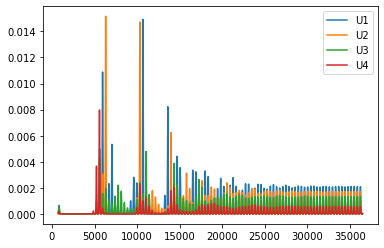

In [25]:
day_dfsH_antigen_cp['homo'][Us][365*2:].plot()

1. Group by 7 days
2. sum every group to get number of cases per week
3. reindex with new index according to number of week

In [26]:
### weekly dataframes

In [27]:
week_dfsH_gen_cp=dict()
week_dfsH_gen_ce=dict()

week_dfsH_antigen_cp=dict()
week_dfsH_antigen_ce=dict()

day_list_dicts=[day_dfsH_gen_cp,day_dfsH_gen_ce,day_dfsH_antigen_cp,day_dfsH_antigen_ce]
week_list_dicts=[week_dfsH_gen_cp,week_dfsH_gen_ce,week_dfsH_antigen_cp,week_dfsH_antigen_ce]

for day_df,week_df in zip(day_list_dicts,week_list_dicts):
    for key in ['homo','hetero']:
        week_df[key]=day_df[key].groupby(pd.cut(day_df[key].index,np.arange(day_df[key].index[0],day_df[key].index[-1],7))).sum()
        
for df in week_list_dicts:
    for key in ['homo','hetero']:
        df[key].set_index(np.arange(0,len(df[key])),inplace=True)
        #week_df[key].set_index(np.arange(week_df[key].index[0],len(week_df[key])),inplace=True)


### Save dataframes to csv

In [36]:
for df,reM_type in zip(week_list_dicts,['gen_cp','gen_ce','antigen_cp','antigen_ce']):
    for key in ['homo','hetero']:
        df[key].to_csv(files_path+'dfsLowR0s_'+reM_type+'_'+key+'.csv')
        #week_df[key].set_index(np.arange(week_df[key].index[0],len(week_df[key])),inplace=True)


In [ ]:
#week_dfsH_gen_cp['homo'][Us].plot()

### Mothly data frames

1. Group by 30 days
2. sum every group to get number of cases per month aprox ie 30 days
3. reindex with new index according to number of  month

In [ ]:
month_dfsH_gen_cp=dict()
month_dfsH_gen_ce=dict()

month_dfsH_antigen_cp=dict()
month_dfsH_antigen_ce=dict()

day_list_dicts=[day_dfsH_gen_cp,day_dfsH_gen_ce,day_dfsH_antigen_cp,day_dfsH_antigen_ce]
month_list_dicts=[month_dfsH_gen_cp,month_dfsH_gen_ce,month_dfsH_antigen_cp,month_dfsH_antigen_ce]

for day_df,month_df in zip(day_list_dicts,month_list_dicts):
    for key in ['homo','hetero']:
        month_df[key]=day_df[key].groupby(pd.cut(day_df[key].index,np.arange(day_df[key].index[0],day_df[key].index[-1],30))).sum()
        
for df in month_list_dicts:
    for key in ['homo','hetero']:
        df[key].set_index(np.arange(0,len(df[key])),inplace=True)
        #month_df[key].set_index(np.arange(month_df[key].index[0],len(month_df[key])),inplace=True)


In [ ]:
#month_dfsH_gen_cp['homo'][Us].plot()

### yearly data frames

In [55]:
year_dfsH_gen_cp=dict()
year_dfsH_gen_ce=dict()

year_dfsH_antigen_cp=dict()
year_dfsH_antigen_ce=dict()

day_list_dicts=[day_dfsH_gen_cp,day_dfsH_gen_ce,day_dfsH_antigen_cp,day_dfsH_antigen_ce]
year_list_dicts=[year_dfsH_gen_cp,year_dfsH_gen_ce,year_dfsH_antigen_cp,year_dfsH_antigen_ce]

for day_df,year_df in zip(day_list_dicts,year_list_dicts):
    for key in ['homo','hetero']:
        year_df[key]=day_df[key].groupby(pd.cut(day_df[key].index,np.arange(day_df[key].index[0],day_df[key].index[-1],365))).sum()
        
for df in year_list_dicts:
    for key in ['homo','hetero']:
        df[key].set_index(np.arange(0,len(df[key])),inplace=True)
        #year_df[key].set_index(np.arange(year_df[key].index[0],len(year_df[key])),inplace=True)


NameError: name 'day_dfsH_gen_cp' is not defined

In [ ]:
#year_dfsH_gen_cp['homo'][Us][2:100].plot()

In [ ]:
#month_dfsH_gen_cp['homo'][Us][10*12:].plot()

In [ ]:
#week_dfsH_gen_cp['homo'][Us][10*52:].plot()

In [ ]:
import matplotlib.pylab as plt

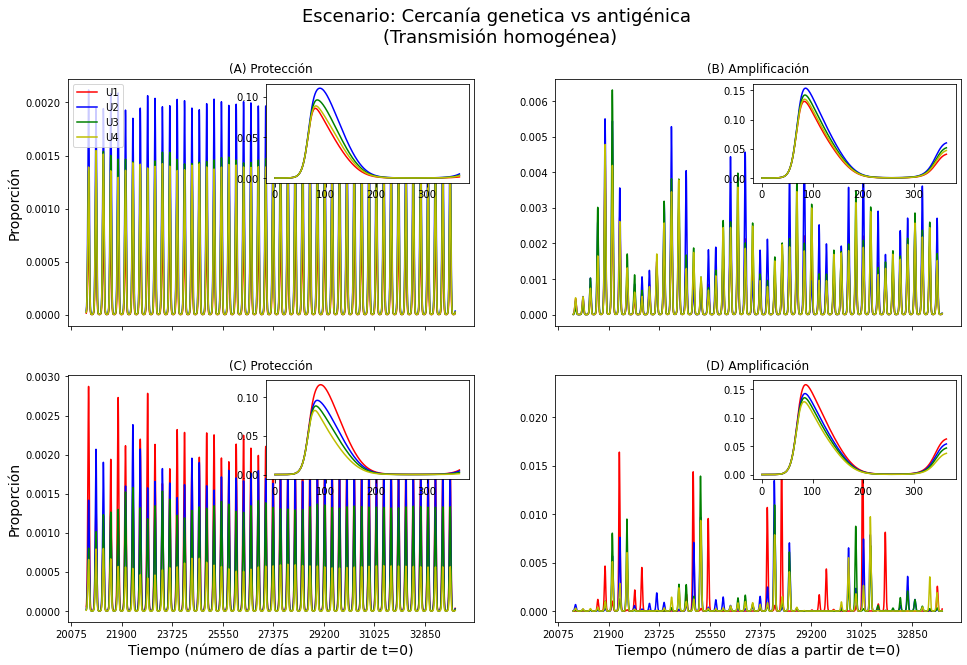

In [64]:
Us=['U1','U2','U3','U4']

fig, axes=plt.subplots(2,2,figsize=(16,10),sharex=True)

colors=['r','b','g','y']

#t1=365*10
t1=365
t_start=365*50
#t_start=365*20
#t_start=0
t_end=365*100


#step=7*10 # week data
step=1 # daily data

cols=Us
cols_type='(Infecciosos)'

wid='50%'
hei='40%'

loc=1

#dataH_homo_cp,dataH_hetero_cp=[dfsH_gen_cp[key] for key in dfsH_gen_cp.keys()]
#dataH_homo_ce,dataH_hetero_ce=[dfsH_gen_ce[key] for key in dfsH_gen_ce.keys()]



plt.suptitle('Escenario: Cercanía genetica vs antigénica \n'+'(Transmisión homogénea)',fontsize=18)

ax11=axes[0,0]


dfsH_gen_cp['homo'][cols][t_start:t_end:step].plot(ax=ax11,color=colors)
ax11.legend(loc='upper left')

ax11_2=inset_axes(ax11,width=wid,height=hei,loc=loc)
dfsH_gen_cp['homo'][cols][:t1:step].plot(ax=ax11_2,color=colors,legend=False,use_index=False)


ax12=axes[0,1]

dfsH_gen_ce['homo'][cols][t_start:t_end:step].plot(ax=ax12,color=colors,legend=False)

ax12_2=inset_axes(ax12,width=wid,height=hei,loc=loc)
dfsH_gen_ce['homo'][cols][:t1:step].plot(ax=ax12_2,color=colors,legend=False)


#-------------------------------------------------------------#
ax21=axes[1,0]


dfsH_antigen_cp['homo'][cols][t_start:t_end:step].plot(ax=ax21,color=colors,legend=False)

ax21_2=inset_axes(ax21,width=wid,height=hei)
dfsH_antigen_cp['homo'][cols][:t1:step].plot(ax=ax21_2,color=colors,legend=False)

ax22=axes[1,1]
dfsH_antigen_ce['homo'][cols][t_start:t_end:step].plot(ax=ax22,color=colors,legend=False)

ax22_2=inset_axes(ax22,width=wid,height=hei)
dfsH_antigen_ce['homo'][cols][:t1:step].plot(ax=ax22_2,color=colors,legend=False)



ax11.set_title('(A) Protección',fontsize=12)
ax12.set_title('(B) Amplificación',fontsize=12)
ax21.set_title('(C) Protección',fontsize=12)
ax22.set_title('(D) Amplificación',fontsize=12)
#if t_end <= 365:
#    step = 1
#    rotation = "horizontal"
#elif t_end <= 365*10:
#    step = 365
#    rotation = "vertical"
#else:
#    step = 10
#    rotation = "vertical"


for ax in [ax11,ax21]:
    ax.set_ylabel('Proporción',fontsize=14)

for ax in [ax21,ax22]:
    ax.set_xlabel('Tiempo (número de días a partir de t=0)',fontsize=14)


    
    
#step=365*50 #each 5 years

step=365*5 #each 5 years


ax=axes[0,0]
#ax.set_xticklabels(np.arange(t_start/10, t_end/10+1, step/10, dtype=np.int), rotation='vertical')
ax.set_xticklabels(np.arange(t_start, t_end+1, step, dtype=np.int))

for axes in [ax11,ax12,ax21,ax22]:
    axes.set_xticklabels(np.arange(t_start, t_end+1, step, dtype=np.int))


# FRO SAVING FIGURE
#plt.savefig(figs_path+'scenImass_suw4v_Us_gen_vs_antigen_50years_N1M1'+'.pdf',format='pdf')




